In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Thermal diffusivity
alpha = 0.01

# Analytic solution for testing:
# u(x, y, t) = sin(pi x) * sin(pi y) * exp(-2 alpha pi^2 t)
def exact_solution(X):
    x = X[:, 0:1]
    y = X[:, 1:2]
    t = X[:, 2:3]
    return np.sin(np.pi * x) * np.sin(np.pi * y) * np.exp(-2 * alpha * np.pi**2 * t)

# PDE definition: u_t = alpha (u_xx + u_yy)
def pde(x, u):
    u_t  = dde.grad.jacobian(u, x, i=0, j=2)  # ∂u/∂t
    u_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)  # ∂²u/∂x²
    u_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)  # ∂²u/∂y²
    return u_t - alpha * (u_xx + u_yy)

# Boundary condition: u = 0 for all t > 0 on domain boundary
def boundary_func(x, on_boundary):
    x = np.atleast_2d(x)
    return on_boundary and np.all(np.squeeze(x[:, 2]) > 1e-8)

# Initial condition: u(x,y,0) = sin(pi x) sin(pi y)
def init_cond(x):
    return np.sin(np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])

def on_initial(x, _):
    x = np.atleast_2d(np.array(x))
    return np.isclose(x[:, 2], 0).squeeze()

# Geometry and time domain
spatial_domain = dde.geometry.Rectangle([0, 0], [1, 1])
time_domain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(spatial_domain, time_domain)

# BC and IC
boundary_cond = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_func)
initial_cond = dde.icbc.IC(geomtime, init_cond, on_initial)

# Dataset for PINN
data = dde.data.TimePDE(
    geomtime,
    pde,
    [boundary_cond, initial_cond],
    num_domain=4000,
    num_boundary=400,
    num_initial=400,
    train_distribution="uniform",
    solution=exact_solution,
    num_test=1000,
)

# Neural net
net = dde.nn.FNN([3] + [50] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

# Training
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=5000)

model.compile("L-BFGS")
model.train()

# Prediction and error evaluation
X_test = geomtime.random_points(10000)
u_pred = model.predict(X_test)
u_true = exact_solution(X_test)

error_rel = np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)
print("Relative L2 error:", error_rel)

Compiling model...
'compile' took 2.596793 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.16e-04, 8.98e-02, 5.01e-01]    [5.59e-04, 8.98e-02, 5.01e-01]    []  


/home/sangwon/.miniconda3/envs/ml/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [3.16e-04, 6.59e-04, 5.72e-04]    [1.84e-04, 6.59e-04, 5.72e-04]    []  
2000      [1.25e-04, 2.51e-04, 1.92e-04]    [5.40e-05, 2.51e-04, 1.92e-04]    []  
3000      [9.36e-05, 1.06e-04, 6.45e-05]    [4.23e-05, 1.06e-04, 6.45e-05]    []  
4000      [7.36e-05, 5.58e-05, 3.11e-05]    [3.70e-05, 5.58e-05, 3.11e-05]    []  
5000      [5.42e-05, 3.25e-05, 1.83e-05]    [2.82e-05, 3.25e-05, 1.83e-05]    []  

Best model at step 5000:
  train loss: 1.05e-04
  test loss: 7.90e-05
  test metric: []

'train' took 62.673264 s

Compiling model...
'compile' took 0.000984 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [5.42e-05, 3.25e-05, 1.83e-05]    [2.82e-05, 3.25e-05, 1.83e-05]    []  
5993      [1.50e-07, 4.58e-08, 4.70e-08]    [7.61e-08, 4.58e-08, 4.70e-08]    []  

Best model at step 5993:
  train loss: 2.43e-07
  test loss: 1.69e-07
  test metric: []

'train' took 60.160849 s

Relative L2 error: 0.0002724072


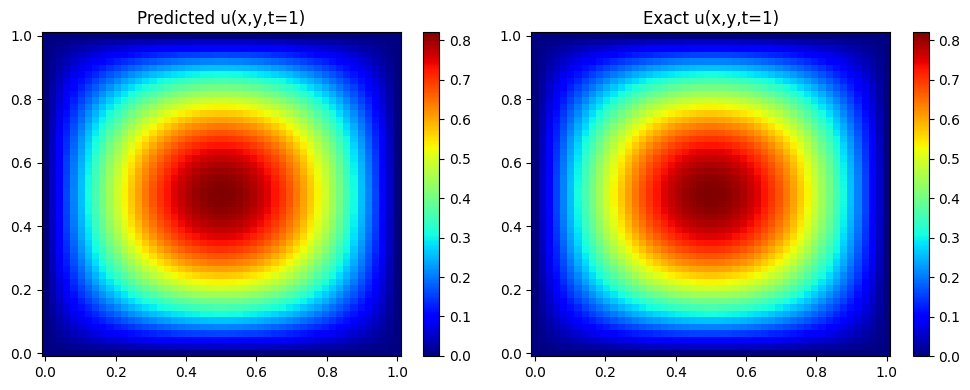

'heat2d_model-5993.pt'

In [3]:
# Plot at final time t=1
N_plot = 50
x = np.linspace(0, 1, N_plot)
y = np.linspace(0, 1, N_plot)
Xg, Yg = np.meshgrid(x, y)
Tg = np.ones_like(Xg) * 1.0
XYT = np.stack([Xg.ravel(), Yg.ravel(), Tg.ravel()], axis=1)

u_pred_plot = model.predict(XYT).reshape(N_plot, N_plot)
u_true_plot = exact_solution(XYT).reshape(N_plot, N_plot)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
pcm1 = axs[0].pcolormesh(Xg, Yg, u_pred_plot, shading="auto", cmap="jet")
axs[0].set_title("Predicted u(x,y,t=1)")
fig.colorbar(pcm1, ax=axs[0])

pcm2 = axs[1].pcolormesh(Xg, Yg, u_true_plot, shading="auto", cmap="jet")
axs[1].set_title("Exact u(x,y,t=1)")
fig.colorbar(pcm2, ax=axs[1])

plt.tight_layout()
plt.show()

# Save model
model.save("heat2d_model")